In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

import ipywidgets as widgets
from IPython.display import display
import pickle


import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

import zuko
import lampe.inference
import lampe.utils
from tqdm.notebook import tqdm_notebook as tqdm
from lampe.utils import GDStep

from itertools import islice
from lampe.data import JointLoader

In [22]:
theta_true = torch.Tensor([0])
prior = torch.distributions.Normal(0, 5)
N = 100
theta_grid = np.linspace(-8, 8, 1000)
N_simu = 50_000

In [23]:
zi = torch.distributions.Normal(theta_true, 1).sample((N,)).squeeze().tolist()
z1, z2 = zi[0], zi[1]

In [24]:
# To compute the true posteriors distributions for every summary statistics
def posterior_z(thetas, z1=z1, z2=z2, sigma_y_2=1):
    """Posterior if we observe z1, z2"""

    def improper_posterior_z(theta, z1=z1, z2=z2):
        likelihood_part = -(np.square(theta - z1) + np.square(theta - z2)) / (
            2 * sigma_y_2**2
        )
        prior_part = np.square(theta) / 50
        res = np.exp(likelihood_part) * np.exp(prior_part)
        return res

    Z_z1_z2, eps = integrate.quad(
        improper_posterior_z, -15, 15
    )  # Integral of p_impropre(θ|z1,z2)
    return [improper_posterior_z(theta, z1, z2) / Z_z1_z2 for theta in thetas]


x = (z1 + z2) / 2


def posterior_x(thetas, x=x, sigma_2_y=1):
    """Posterior when observing x=mean(z1, z2)"""

    def improper_posterior_x(theta, x=x):
        likelihood_part = -np.square(theta - x) / sigma_2_y**2
        prior_part = -np.square(theta) / 50
        return np.exp(likelihood_part) * np.exp(prior_part)

    z_x, eps = integrate.quad(improper_posterior_x, -15, 15)
    return [improper_posterior_x(theta, x) / z_x for theta in thetas]


x = np.mean(zi)


def posterior_x_N(thetas, x=x, sigma_2_y=1):
    """Posterior when observing x= mean(z1, z2... ,zn)"""

    def improper_posterior_x_N(theta, x=x):
        likelihood_part = -N * np.square(theta - x) / (2 * sigma_2_y**2)
        prior_part = -np.square(theta) / 50
        return np.exp(likelihood_part) * np.exp(prior_part)

    z_x_n, eps = integrate.quad(improper_posterior_x_N, -15, 15)

    return [improper_posterior_x_N(theta, x) / z_x_n for theta in thetas]


x1 = np.mean(zi)
x2 = np.var(zi)


def posterior_summaries(thetas, x1=x1, x2=x2, sigma_2_y=1):
    """Posterior when observing x= mean(z1...zn), var(z1...zn)"""

    def improper_posterior_summaries(theta, x1=x1, x2=x2):
        likelihood_x1_part = -N * np.square(theta - x1) / (2 * sigma_2_y**2)
        likelihood_x2_part = (
            -0.5 * np.square(sigma_2_y - x2) / (2 * np.square(sigma_2_y) / N)
        )
        prior_part = -np.square(theta) / 50
        return (
            np.exp(likelihood_x1_part) * np.exp(likelihood_x2_part) * np.exp(prior_part)
        )

    z_summaries, eps = integrate.quad(improper_posterior_summaries, -25, 25)
    return [
        improper_posterior_summaries(theta, x1, x2) / z_summaries for theta in thetas
    ]


# x=np.var(zi)
def posterior_var(thetas, x=x):
    """Posterior when observing x= var(z1...zn)"""

    def improper_posterior_var(theta, x=x):
        likelihood_part = -N * np.square(x - 1)
        prior_part = -np.square(theta) / 50
        return np.exp(likelihood_part) * np.exp(prior_part)

    z_summaries, eps = integrate.quad(improper_posterior_var, -25, 25)
    return [improper_posterior_var(theta, x) / z_summaries for theta in thetas]

In [25]:
def get_true_post(summaries, x_star, sigma_y_2=1):
    theta_grid_t = theta_grid  # Convert theta_grid to a torch tensor

    if "two_z" == summaries:
        # We observe z1, z2
        post = posterior_z(theta_grid_t, x_star[0], x_star[1], sigma_y_2)
        dist = posterior_z
    elif "mean_two_z" == summaries:
        # We observed x = mean(z1, z2)
        post = posterior_x(theta_grid_t, x_star, sigma_y_2)
        dist = posterior_x
    elif "var" == summaries:
        # We observe x = var(z1...zn)
        post = posterior_var(theta_grid_t, x_star, sigma_y_2)
        dist = posterior_var
    elif "var" in summaries and "mean" in summaries:
        # We observe x = (x1, x2) = (mean, var)
        post = posterior_summaries(theta_grid_t, x_star[0], x_star[1], sigma_y_2)
        dist = posterior_summaries
    elif "mean" == summaries:
        # We observe x = mean(z1, ... z100)
        post = posterior_x_N(theta_grid_t, x_star, sigma_y_2)
        dist = posterior_x_N

    # post = torch.stack(post).cuda()  # Move post to CUDA
    return post

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [27]:
def generate_data(thetas, sigma_y_2=1):
    N = thetas.shape[0]
    sigma_eps = sigma_y_2 - 1
    res = {}
    means = torch.zeros((N, 1), device=device)
    means_two_z = torch.zeros((N, 1), device=device)
    means_and_vars = torch.zeros((N, 2), device=device)
    vars = torch.zeros((N, 1), device=device)
    raws = torch.zeros((N, 1), device=device)
    two_z_l = torch.zeros((N, 2), device=device)

    for i, theta in enumerate(thetas):
        z = torch.distributions.Normal(theta, 1).sample((100,)).to(device)
        mean = z.mean()
        var = z.var()
        z0, z1 = z[0], z[1]
        mean_two_z = torch.mean(torch.stack([z0, z1]))

        means[i] = mean
        means_two_z[i] = mean_two_z.unsqueeze_(0)
        means_and_vars[i] = torch.stack(
            [mean.unsqueeze_(0), var.unsqueeze_(0)]
        ).squeeze_()
        two_z_l[i] = torch.stack([z0, z1]).squeeze_()
        vars[i] = var
        raws[i] = z0

    res["mean"] = {"x": means}
    res["mean_two_z"] = {"x": means_two_z}
    res["mean_and_var"] = {"x": means_and_vars}
    res["two_z"] = {"x": two_z_l}
    res["raw_z"] = {"x": raws}
    res["var"] = {"x": vars}

    for key in res.keys():
        norm_min = np.inf
        for n_run in range(10):
            eps = (
                torch.distributions.Normal(
                    torch.zeros_like(res[key]["x"]), np.sqrt(sigma_eps)
                )
                .sample()
                .to(device)
            )
            if torch.norm(eps) < norm_min:
                epsilons = eps
                norm_min = torch.norm(eps)
        res[key]["eps"] = epsilons
        scale_mean, scale_std = res[key]["x"].mean(0), res[key]["x"].std(0)
        res[key]["scale_parameters"] = scale_mean, scale_std
        res[key]["scaled_x"] = (res[key]["x"] - scale_mean) / scale_std

    return res

In [28]:
summary = "mean_and_var"
sigma_2_y = 2

In [29]:
def scale(quantity):
    mean = quantity.mean(0)
    std = quantity.std(0)
    return (quantity - mean) / std, mean, std

In [30]:
def build_nsf(features, context):
    """Callable to instantiate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5).to(device)


def train_flow(flow, loss, theta, x, theta_test, x_test):
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    theta_test = theta_test.unsqueeze(-1).to(device)
    data = lampe.data.JointDataset(theta.to(device), x.to(device))
    loader = lampe.data.DataLoader(data, 256)

    with torch.no_grad():
        min_loss = loss(theta_test, x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar

    flow.train()

    for epoch in range(50):
        for theta_batch, x_batch in loader:
            theta_batch = theta_batch.unsqueeze(-1).to(device)
            x_batch = x_batch.to(device)
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test.to(device))
            min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
            if (
                len(min_loss_list) - np.argmin(min_loss_list) > 5
            ):  # No improvement in loss(test) for the last 5 iterations
                # Early stop

                break

    flow.eval()
    return flow


def create_train_flow(summaries, theta, data, theta_test, data_test):
    shape_x = lambda x: 2 if x == "mean_and_var" or x == "two_z" else 1
    flow = lampe.inference.NPE(
        theta_dim=1, x_dim=shape_x(summaries), build=build_nsf
    ).to(device)
    loss = lampe.inference.NPELoss(flow).to(device)
    x = data[summaries]["scaled_x"].to(device)
    x_test = data_test[summaries]["scaled_x"].to(device)
    flow = train_flow(flow, loss, theta, x, theta_test, x_test)
    return flow


theta = prior.sample((N_simu,)).to(device)
theta_test = prior.sample((N_simu // 10,)).to(device)
theta_scaled, theta_means, theta_stds = scale(theta)
theta_test_scaled, _, __ = scale(theta_test)
data = generate_data(theta, sigma_2_y)
data_test = generate_data(theta_test, sigma_2_y)
q_NPE = create_train_flow(summary, theta, data, theta_test, data_test)  #!

In [31]:
true_obs_data = generate_data(theta_true, sigma_2_y)
x0 = true_obs_data[summary]["x"].to(device)
y0 = x0 + true_obs_data[summary]["eps"].to(device)

x0_scaled = (x0 - data[summary]["scale_parameters"][0]) / data[summary][
    "scale_parameters"
][1]
y0_scaled = (y0 - data[summary]["scale_parameters"][0]) / data[summary][
    "scale_parameters"
][1]

In [32]:
def train_unconditional_flow(flow, loss, x, x_test):
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
    loader = torch.utils.data.DataLoader(x.to(device), 256)

    with torch.no_grad():
        min_loss = loss(x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar

    flow.train()

    for epoch in range(50):
        for x_batch in loader:
            x_batch = x_batch.to(device)
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test.to(device))
            min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
            if (
                len(min_loss_list) - np.argmin(min_loss_list) > 5
            ):  # No improvement in loss(test) for the last 5 iterations
                # Early stop

                break
    flow.eval()
    return flow


def create_train_unconditional_flow(summaries, data, data_test):
    shape_x = lambda x: 2 if x == "mean_and_var" or x == "two_z" else 1
    flow = zuko.flows.NAF(features=shape_x(summaries), context=0).to(device)  #!
    loss = lambda x: -flow().log_prob(x).mean()
    x = data[summaries]["scaled_x"].to(device)
    x_test = data_test[summaries]["scaled_x"].to(device)
    flow = train_unconditional_flow(flow, loss, x, x_test)
    return flow


q_x_NF = create_train_unconditional_flow(summary, data, data_test)

In [34]:
npe_samples_x = q_NPE.flow(x0_scaled).sample((20_000,))
npe_samples_rescaled_x = (npe_samples_x + theta_means) * theta_stds
true_post = get_true_post(summary, x0.squeeze().cpu().numpy())

npe_samples_y = q_NPE.flow(y0_scaled).sample( (20_000,))
npe_samples_rescaled_y = (npe_samples_y + theta_means) * theta_stds
theoritical_post_y = get_true_post(summary, y0.squeeze().cpu().numpy())

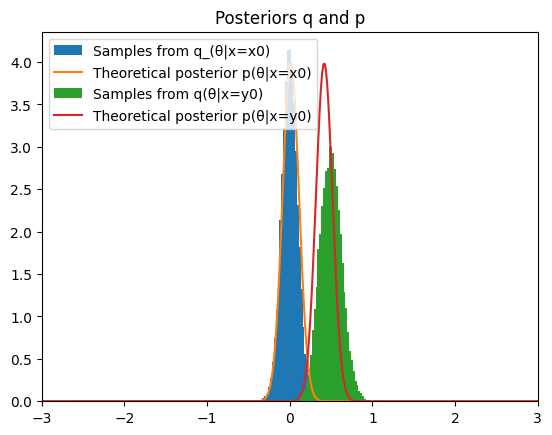

In [35]:
fig, ax = plt.subplots()
ax.hist(
    npe_samples_x.cpu().squeeze().cpu(),
    bins=400,
    density=True,
    label="Samples from q_(θ|x=x0)",
)  #!
ax.plot(theta_grid, true_post, label="Theoretical posterior p(θ|x=x0)")
ax.hist(
    npe_samples_y.cpu().squeeze(),
    bins=200,
    density=True,
    label="Samples from q(θ|x=y0)",
)
ax.plot(theta_grid, theoritical_post_y, label="Theoretical posterior p(θ|x=y0)")

ax.set_title("Posteriors q and p")
ax.set_xlim(-3, 3)
ax.legend()
plt.show()

In [36]:
M = 100_000
warm_up_steps = 20_000

sigma = 0.01
tau = 0.25
rho = 1 / 2

In [37]:
import torch.distributions as dist


# Define the proposal function
def proposal(x_curr):
    return x_curr + dist.Normal(0, 1).sample(x_curr.shape).to(device)


# Define the f function
def f(y0, x, rho, sigma, tau, q_x_NF):
    D = 2
    res = torch.zeros_like(y0)

    for j in range(D):
        xj = x[j]
        yj = y0[j]
        zj = dist.Bernoulli(rho).sample().to(device)
        if not zj:
            spike_dist = dist.Normal(xj.detach(), torch.tensor(sigma).to(device))
            res[j] = torch.exp(spike_dist.log_prob(yj))
        else:
            slab_dist = dist.Cauchy(xj.detach(), torch.tensor(tau).to(device))
            res[j] = torch.exp(slab_dist.log_prob(yj))
    return res * torch.exp(q_x_NF().log_prob(x))


def mcmc(x0, warm_up_steps, M, y0, rho, sigma, tau, q_x_NF):
    x_curr = x0.to(device)
    my_samples = torch.empty((warm_up_steps + M, x0.shape[0])).to(device)
    log_f_x_curr = f(y0, x_curr, rho, sigma, tau, q_x_NF).log()

    for i in tqdm(range(warm_up_steps + M)):
        x_star = proposal(x_curr)
        log_f_x_star = f(y0, x_star, rho, sigma, tau, q_x_NF).log()

        log_a = log_f_x_star - log_f_x_curr

        a = torch.exp(log_a)

        u = torch.cuda.FloatTensor(a.shape).uniform_().to(device)

        mask = u < a

        x_curr = torch.where(mask, x_star, x_curr)
        log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)

        my_samples[i] = x_curr

    my_samples = my_samples[warm_up_steps:]
    return my_samples

In [38]:
with torch.no_grad():
    xm = mcmc(
        torch.zeros_like(data[summary]["x"][0]).to(device),
        warm_up_steps,
        M,
        y0_scaled.squeeze().to(device),
        rho,
        sigma,
        tau,
        q_x_NF,
    )

  0%|          | 0/120000 [00:00<?, ?it/s]

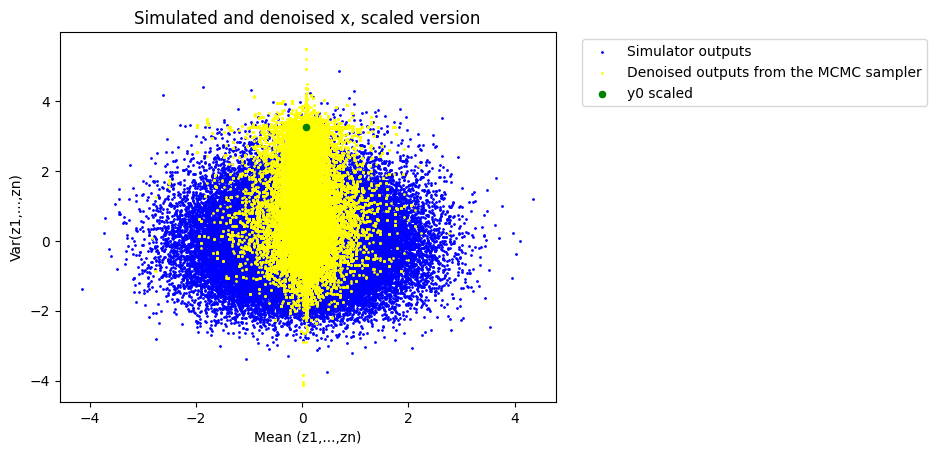

In [39]:
fig, ax = plt.subplots()

ax.scatter(
    x=data[summary]["scaled_x"][:, 0].cpu(),
    y=data[summary]["scaled_x"][:, 1].cpu(),
    color="blue",
    label="Simulator outputs",
    s=1,
)
ax.scatter(
    x=xm[:, 0].cpu(),
    y=xm[:, 1].cpu(),
    label="Denoised outputs from the MCMC sampler",
    color="yellow",
    s=1,
)
ax.scatter(
    x=y0_scaled.cpu()[:, 0],
    y=y0_scaled.cpu()[:, 1],
    label="y0 scaled",
    color="green",
    s=20,
)
ax.set_xlabel("Mean (z1,...,zn)")
ax.set_ylabel("Var(z1,...,zn)")
ax.set_title("Simulated and denoised x, scaled version")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [42]:
rnpe_samples = q_NPE.flow(xm).sample()
rnpe_samples_unscaled = (rnpe_samples + theta_means) * theta_stds

In [43]:
true_post_y = posterior_summaries(
    theta_grid, y0.cpu().squeeze()[0].item(), y0.cpu().squeeze()[1].item(), sigma_2_y
)

In [46]:
npe_samples = q_NPE.flow(y0_scaled).sample((20_000,))
true_post = get_true_post(summary, y0.squeeze().cpu().numpy())

(-5.0, 5.0)

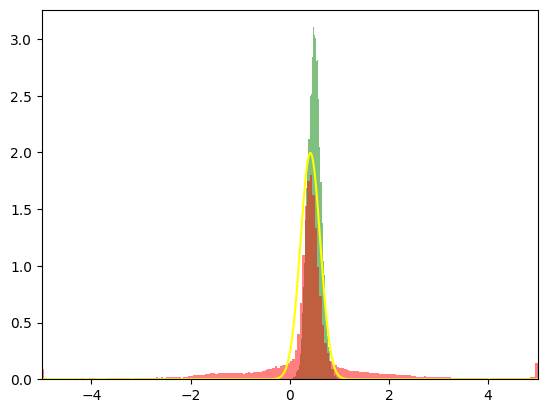

In [47]:
plt.hist(
    npe_samples.squeeze().cpu(),
    bins=200,
    density=True,
    color="green",
    alpha=0.5,
    label="NPE samples q(θ|y0)",
)
plt.hist(
    rnpe_samples.squeeze().cpu(),
    bins=200,
    density=True,
    color="red",
    alpha=0.5,
    label="RNPE samples q(θ|y0)",
)
plt.plot(theta_grid, true_post_y, color="yellow", label=" p(θ|y0) under the true DGP")
plt.xlim(-5, 5)

In [48]:
def compute_distances(true_post_density, sample):
    true_post_samples = np.random.choice(
        theta_grid, size=100_000, p=true_post_density / sum(true_post_density)
    )
    mean_true, std_true = np.mean(true_post_samples), np.std(true_post_samples)
    mean_sample, std_sample = np.mean(sample), np.std(sample)
    return np.square(mean_true - mean_sample) + np.square(np.log(std_true / std_sample))

In [56]:
def computes_and_prepare_graphs(sigma_2):
    plt.close()
    summaries = ["two_z", "mean_two_z", "mean", "mean_and_var"]
    summaries = ["mean_and_var"]
    summary = "mean_and_var"  #!

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    i = 0

    n_runs = 10
    x0_l = []
    y0_l = []
    npe_samples_l = []
    rnpe_samples_l = []
    distance_npe_l = []
    distance_rnpe_l = []
    data_l = []
    xm_l = []
    x0_scaled_l, y0_scaled_l = [], []
    true_post_samples_l = []
    true_post_y_l = []
    distance_l = []
    for i in range(n_runs):
        # Simulating data
        theta = prior.sample((N_simu,)).to(device)
        theta_test = prior.sample((N_simu // 10,))
        data = generate_data(theta, sigma_2)
        data_l.append(data)
        data_test = generate_data(theta_test, sigma_2)
        # Creating and training both flows
        q_NPE = create_train_flow(summary, theta, data, theta_test, data_test)
        q_x_NF = create_train_unconditional_flow(summary, data, data_test)
        # Generating the observed data
        true_obs_data_l = []

        true_obs_data_l.append(generate_data(theta_true, sigma_2))

        x0_l.append(true_obs_data_l[-1][summary]["x"])
        y0_l.append(x0_l[-1] + true_obs_data_l[-1][summary]["eps"])
        x0_scaled_l.append(
            (x0_l[-1] - data[summary]["scale_parameters"][0])
            / data[summary]["scale_parameters"][1]
        )
        y0_scaled_l.append(
            (y0_l[-1] - data[summary]["scale_parameters"][0])
            / data[summary]["scale_parameters"][1]
        )
        # Denoising x from the observed y
        with torch.no_grad():
            xm_l.append(
                mcmc(
                    torch.zeros_like(data[summary]["x"][0]),
                    warm_up_steps,
                    M,
                    y0_scaled_l[-1].squeeze().to(device),
                    rho,
                    sigma,
                    tau,
                    q_x_NF,
                )
            )
        # Sampling
        npe_samples_l.append(q_NPE.flow(y0_scaled_l[-1]).sample( (10_000,)))
        rnpe_samples_l.append(q_NPE.flow(xm_l[-1]).sample())
        true_post_y_l.append(
            get_true_post(summary, y0_l[-1].squeeze().cpu().numpy(), sigma_2)
        )
        true_post_samples_l.append(
            np.random.choice(
                theta_grid, size=100_000, p=true_post_y_l[-1] / sum(true_post_y_l[-1])
            )
        )
        # Distance between the true expected distribution and the actual samples form the npe
        distance_npe_l.append(
            compute_distances(
                true_post_y_l[-1], npe_samples_l[-1].squeeze().cpu().numpy()
            )
        )
        distance_rnpe_l.append(
            compute_distances(
                true_post_y_l[-1], rnpe_samples_l[-1].squeeze().cpu().numpy()
            )
        )
        distance_l.append(
            torch.norm(npe_samples_l[-1].mean(0) - rnpe_samples_l[-1]).mean(0).item()
        )
    distance_npe = np.mean(distance_npe_l)
    distance_rnpe = np.mean(distance_rnpe_l)
    argmax = np.argmax(distance_l)
    x0 = x0_l[argmax]
    y0 = y0_l[argmax]
    npe_samples = npe_samples_l[argmax]
    rnpe_samples = rnpe_samples_l[argmax]
    true_post_y = true_post_y_l[argmax]
    xm = xm_l[argmax]
    y0_scaled = y0_scaled_l[argmax]
    data = data_l[argmax]

    ax[0].hist(
        npe_samples.squeeze(),
        bins=200,
        density=True,
        color="green",
        alpha=0.5,
        label="NPE samples q(θ|y0)",
    )
    ax[0].hist(
        rnpe_samples.squeeze(),
        bins=200,
        density=True,
        color="red",
        alpha=0.5,
        label="RNPE samples q(θ|y0)",
    )
    ax[0].plot(
        theta_grid, true_post_y, color="yellow", label=" p(θ|y0) under the true DGP"
    )
    ax[0].set_xlim(-4, 4)
    ax[0].set_title("Samples from NPE and RNPE")
    ax[1].scatter(
        x=data[summary]["scaled_x"][:, 0].cpu(),
        y=data[summary]["scaled_x"][:, 1].cpu(),
        color="blue",
        label="Simulator outputs",
        s=1,
    )
    ax[1].scatter(
        x=xm[:, 0].cpu(),
        y=xm[:, 1].cpu(),
        label="Denoised outputs from the MCMC sampler",
        color="yellow",
        s=1,
    )
    ax[1].scatter(
        x=y0_scaled.cpu()[:, 0],
        y=y0_scaled.cpu()[:, 1],
        label="y0 scaled",
        color="green",
        s=20,
    )
    ax[1].set_title(" Simulated and denoised x, scaled version")
    i += 1
    fig.suptitle(f"Estimations with sigma² = {sigma_2}")
    return fig, npe_samples, rnpe_samples, x0, y0, distance_npe, distance_rnpe

Corruption:   0%|          | 0/6 [00:00<?, ?Sigma²/s]

1.0


  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

KeyboardInterrupt: 

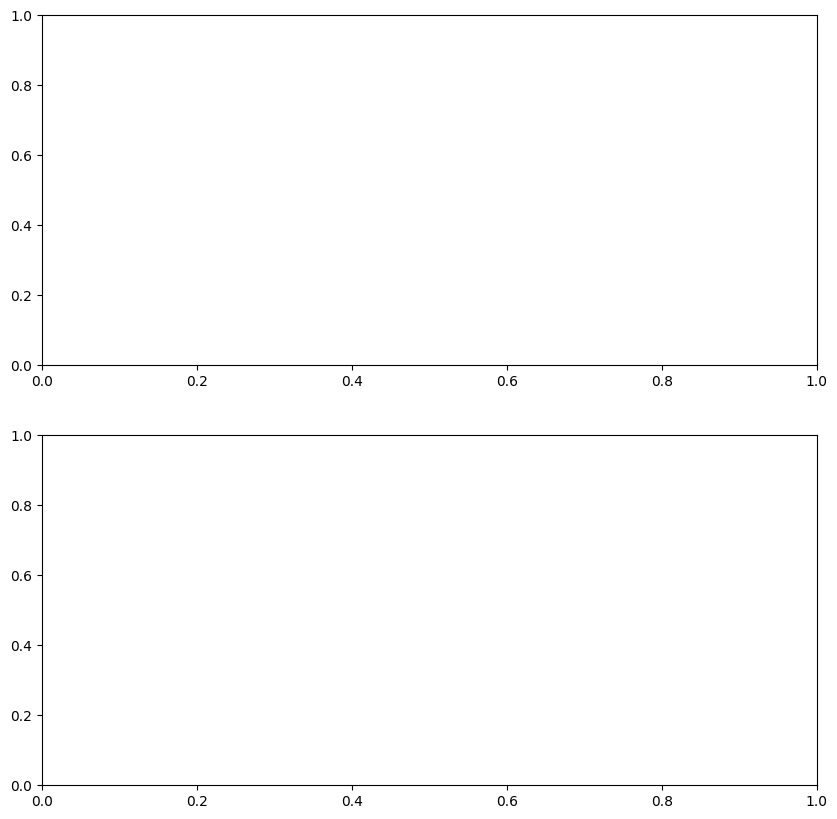

In [57]:
results = {}
sigmas_2 = np.arange(1, 4, 0.5)
with tqdm(sigmas_2, unit="Sigma²", desc="Corruption") as tq:
    for sigma_2 in tq:
        print(sigma_2)
        results[sigma_2] = {}
        (
            results[sigma_2]["figure"],
            results[sigma_2]["npe_samples"],
            results[sigma_2]["rnpe_samples"],
            results[sigma_2]["x0"],
            results[sigma_2]["y0"],
            results[sigma_2]["distance_npe"],
            results[sigma_2]["distance_rnpe"],
        ) = computes_and_prepare_graphs(sigma_2)

In [ ]:
@widgets.interact(sigma_2=sigmas_2)
def plot_posteriors_widget(sigma_2=1):
    plt.close()
    return results[sigma_2]["figure"]

interactive(children=(Dropdown(description='sigma_2', options=(1.0, 1.5, 2.0, 2.5, 3.0, 3.5), value=1.0), Outp…